# Lagrangian particle demonstration in a periodic domain. Particles are simulated in the Southern Ocean AVISO altimetry velocity field.

### Wenrui Jiang, Tom Haine Feb '23

In [1]:
import cartopy.crs as ccrs
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

### The AVISO velocity field dataset is a lat-lon grid with staggered velocity. It's a snapshot from a single time (see below).

In [2]:
!wget https://zenodo.org/record/7838605/files/aviso_example.nc     # Comment this line if you already have the file (to save time).

--2023-04-18 08:47:16--  https://zenodo.org/record/7838605/files/aviso_example.nc
Resolving zenodo.org (zenodo.org)... 188.185.124.72
Connecting to zenodo.org (zenodo.org)|188.185.124.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 98016669 (93M) [application/octet-stream]
Saving to: ‘aviso_example.nc.1’

aviso_example.nc.1  100%[===================>]  93.48M   716KB/s    in 2m 19s  

2023-04-18 08:49:36 (688 KB/s) - ‘aviso_example.nc.1’ saved [98016669/98016669]



In [3]:
ds = xr.open_dataset('aviso_example.nc')
ds

<xarray.Dataset>
Dimensions:  (X: 3600, Xp1: 3600, Y: 1700, Yp1: 1700, time: 1)
Coordinates:
  * X        (X) float32 -179.9 -179.8 -179.7 -179.6 ... 179.7 179.8 179.9 180.0
  * Xp1      (Xp1) float32 -179.9 -179.9 -179.8 -179.6 ... 179.8 179.9 179.9
  * Y        (Y) float32 -80.1 -80.0 -79.9 -79.8 -79.7 ... 89.5 89.6 89.7 89.8
  * Yp1      (Yp1) float32 -80.15 -80.05 -79.95 -79.85 ... 89.55 89.65 89.75
  * time     (time) datetime64[ns] 2017-01-01
Data variables:
    u        (Yp1, X) float64 ...
    v        (Y, Xp1) float64 ...
    lon      (X) float32 ...
    lat      (Y) float32 ...
Attributes: (12/42)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Sea Surface Height measured by Altimetry...
    contact:                         aviso@altimetry.fr
    creator_email:                   aviso@altimetry.fr
    ...                              ...
    summary:                         CLS Delayed-Time Level-4 sea surface hei...
    time_coverage_duration:          P1D
    time_coverage_end:               2017-01-01T12:00:00Z
    time_coverage_resolution:        P1D
    time_coverage_start:             2016-12-31T12:00:00Z
    title:                           DT merged all satellites Global Gridded ...

### Initialize OceInterp package. Then create the `OceData` object which provides methods to translate between lat-lon and grid-oriented coords

In [4]:
import OceInterp as oi
oce = oi.OceData(ds)

#### The object also contains a `tp` (topology) object. It looks at the shape of the coordinate data. In this case, based on longitude range, it thinks the type is `x_periodic`, which is correct for the Southern Ocean.

In [5]:
oce.tp.typ

'x_periodic'

### We've prepared the bathtub that the ducks are going to swim (passively drift) in. Now decide where and when to drop them. 

#### We need a 1D `numpy` array of `lon, lat, dep`, and `time`. It is as simple as that.

In [6]:
# Set the number of particles here.
N = int(9e2)

# Increase this if you want more in x direction.
skew = 3

# Change the vertical depth of the particles here.
sqrtN = int(np.sqrt(N))

# Change the horizontal range here. 
x = np.linspace(-180,180,sqrtN*skew)
y = np.linspace(-50,-70,sqrtN//skew)

### Here is where the particles start on the map:

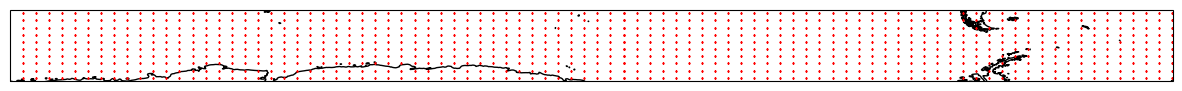

In [7]:
x,y = np.meshgrid(x,y)
x = x.ravel()
y = y.ravel()
plt.figure(figsize=(15,6))
ax = plt.axes(projection = ccrs.PlateCarree(central_longitude=170.0))
ax.plot(x,y,'r+',markersize = 1,transform = ccrs.PlateCarree())
ax.coastlines()
plt.show()

### The AVISO velocity data only has the horizontal velocity component, and is independent of depth. So the `z` dimension is not needed. 

In [8]:
z = None

### The AVISO velocity field is a snapshot and does not have a time dimension. Therefore, the time here only refers to the particle trajectories.

#### The date does not matter, but the duration does (see below). The standard format is seconds since `1970-01-01 00:00`.

In [9]:
start_time = '2000-01-01'
t = (np.array([np.datetime64(start_time) for i in x])
     -np.datetime64('1970-01-01'))/np.timedelta64(1, 's')

### Define the duration of the simulation (end before start means integrate backwards in time).

In [10]:
tf = (np.datetime64('2000-02-01')
     -np.datetime64('1970-01-01'))/np.timedelta64(1, 's')

### Now create the `OceInterp.lagrangian.particle` object.

In [11]:
p = oi.particle(x = x,y=y,z=z,t=t,
                data = oce,
                # save_raw = True,
                # transport = True,
                uname = 'u',vname = 'v',wname = None)
p

### Perform the particle trajectory simulation.

#### Notice how we define when to dump output (`normal_stops`) and when to update the velocity field (`update_stops`). By default, the `stops` returned by the integration is the combination (union) of `normal_stops` and `update_stops`. `raw` is a list of `OceInterp.eulerian.position` objects with the same length as `stops`.

In [12]:
normal_stops = np.linspace(t[0],tf,10)
stops,raw = p.to_list_of_time(normal_stops = normal_stops,update_stops = [])


2000-01-01T00:00:00
0 left 
2000-01-04T10:40:00
900 left 776 left 693 left 578 left 490 left 409 left 338 left 284 left 250 left 221 left 187 left 160 left 129 left 109 left 93 left 79 left 59 left 46 left 39 left 37 left 27 left 20 left 17 left 13 left 11 left 10 left 9 left 9 left 9 left 6 left 6 left 5 left 4 left 3 left 2 left 2 left 2 left 1 left 1 left 1 left 
2000-01-07T21:20:00
900 left 773 left 666 left 537 left 442 left 366 left 315 left 267 left 225 left 188 left 162 left 139 left 113 left 96 left 77 left 65 left 57 left 43 left 37 left 27 left 20 left 16 left 11 left 10 left 9 left 7 left 5 left 4 left 3 left 3 left 3 left 3 left 2 left 2 left 1 left 1 left 1 left 1 left 
2000-01-11T08:00:00
900 left 779 left 654 left 547 left 458 left 385 left 331 left 293 left 249 left 202 left 171 left 142 left 119 left 111 left 95 left 86 left 69 left 62 left 49 left 38 left 31 left 22 left 17 left 14 left 11 left 9 left 9 left 8 left 7 left 7 left 5 left 5 left 5 left 2 left 2 left 2 

### Extract the information from the position objects.

In [13]:
lons = np.array([pt.lon for pt in raw]).T
lats = np.array([pt.lat for pt in raw]).T

### Some particles passed through the dateline (periodic boundary). Here is some pre-processing to handle the plot.

In [14]:
for i in range(len(lons)):
    diff = np.diff(lons[i])
    
    if max(abs(diff))>330:
        for j in np.where(abs(diff)>300)[0]:
            j = int(j)
            lons[i,j+1:] -= np.sign(diff[j])*360

## Here are the trajectories:

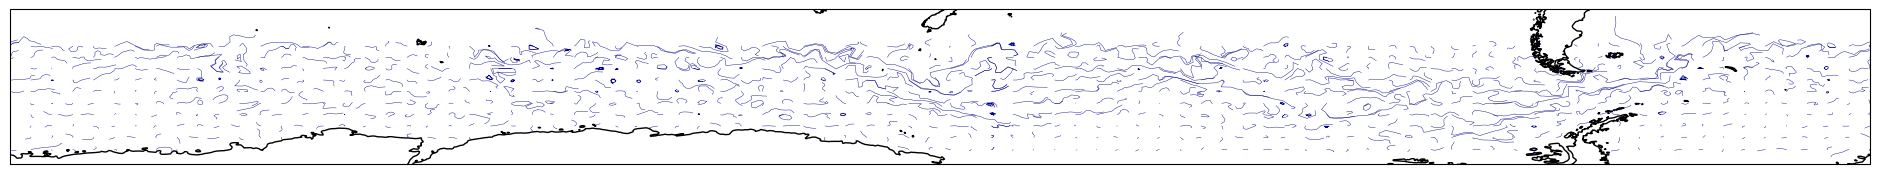

In [15]:
plt.figure(figsize=(24,6))
ax = plt.axes(projection = ccrs.PlateCarree(central_longitude=170.0))
ax.plot(lons.T,lats.T,'darkblue',lw = 0.3,transform = ccrs.PlateCarree())
ax.coastlines()